In [154]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
from mpl_toolkits.mplot3d import Axes3D

In [20]:
def plot_image(root, name):
    I1 = Image.open(root + '/data/' + name + '1.jpg')
    I2 = Image.open(root + '/data/' + name + '2.jpg')
    matches = np.loadtxt(root + '/data/' + name + '_matches.txt')
    N = len(matches)
    
    I3 = np.zeros((I1.size[1],I1.size[0]*2,3) )
    I3[:,:I1.size[0],:] = I1;
    I3[:,I1.size[0]:,:] = I2;
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I3).astype(float))
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
    
    plt.savefig(root + '/output/'+ name + '_matches.svg', format='svg')
    
    plt.show()
    
    I1 = np.array(I1)
    I2 = np.array(I2)
    return I1,I2,matches
    



In [86]:
def plot_epipolar(matches,root, I2, name):
    N = len(matches)
    F = fit_fundamental(matches, 'normalize'); # this is a function that you should write
    M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose() # transform points from 
    
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
    pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
    closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
    
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I2).astype(float))
    ax.plot(matches[:,2],matches[:,3],  '+r')
    ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
    
    plt.savefig(root + '/output/'+ name + '.svg', format='svg')
    
    plt.show()

In [81]:
def fit_fundamental(matches,algo):
    img_p1 = matches[:, 0:2]
    img_p2 = matches[:, 2:4]
    
    if algo == 'normalize':
        img_p1, T_1 = normalize(img_p1)
        img_p2, T_2 = normalize(img_p2)
    
    random_idx = random.sample(range(0, matches.shape[0]), k=8)
    pairs_1 = img_p1[random_idx]
    pairs_2 = img_p2[random_idx]
    
    cons = []
    for i in range(pairs_1.shape[0]):
        p1 = pairs_1[i]
        p2 = pairs_2[i]
        cons.append([p2[0]*p1[0], p2[0]*p1[1], p2[0], p2[1]*p1[0], p2[1]*p1[1], p2[1], p1[0], p1[1], 1])
        
    cons = np.array(cons)
    
    u, s, vh = np.linalg.svd(cons, full_matrices=True)
    vh = np.array(vh)
    cons_matrix = vh[vh.shape[0]-1].reshape((3,3))
    factor = cons_matrix[2,2]
    cons_matrix = cons_matrix/factor
    
    u, s, vh = np.linalg.svd(cons_matrix, full_matrices=True)
    sing_vals = np.diag(s)
    sing_vals[-1] = 0
    F = np.dot(u, np.dot(sing_vals, vh))
    
    fund_matrix = np.dot(np.dot(T_2.T, F), T_1)
    
    return fund_matrix
    

In [39]:
def normalize(points):
    mu = np.mean(points, axis=0)
    
    std_x = np.std(points[:, 0])
    std_y = np.std(points[:, 1])
    
    trans_matrix = np.array([[np.sqrt(2)/std_x, 0, (-np.sqrt(2)/std_x)*mu[0]],
                            [0, np.sqrt(2)/std_y, (-np.sqrt(2)/std_y)*mu[1]],
                            [0,0,1]])
    
    points = np.concatenate((points, np.ones((points.shape[0], 1))), axis=1)
    normal_matrix = np.dot(trans_matrix, points.T).T
    
    return normal_matrix[:, 0:2], trans_matrix

In [166]:
def camera_calibration(root, name, matches):
    txt_data = np.loadtxt(root + '/data/' + name)
    print(txt_data.shape)
    print(matches.shape)
    for i in range(matches.shape[0]):
        cross_matrix = np.array()
        
    return 0

In [88]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


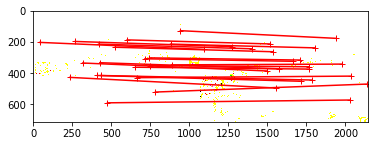

(20, 3)
(20, 4)


In [167]:
root= os.getcwd()
name = 'lab_3d.txt'
txt_data = np.loadtxt(root + '/data/' + name)
I1, I2, matches = plot_image(root, 'lab')
points_1 = matches[:, 0:2]
points_2 = matches[:, 2:4]
projection_matrix = camera_calibration(root, name, matches)
#print(evaluate_points(projection_matrix, points_1, txt_data))

In [90]:
def fund_estimation():
    root= os.getcwd()
    name = 'lab'
    I1, I2, matches = plot_image(root, 'lab')
    print(matches.shape)
    F = fit_fundamental(matches, 'normalize')
    print(F)
    plot_epipolar(matches, root, I2, name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


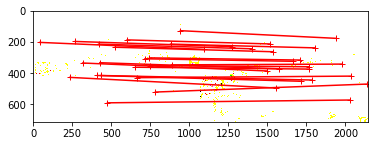

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(20, 4)
[[-7.55595822e-06  6.46029404e-06 -7.11460966e-03]
 [-1.75136598e-04 -1.82565105e-04 -8.57908716e-02]
 [ 5.07162968e-02  2.88592067e-01 -3.12782546e+01]]


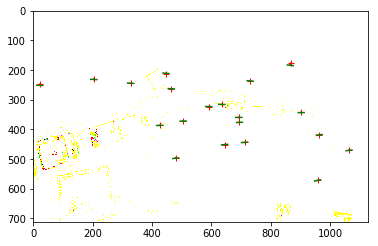

In [91]:
fund_estimation()

In [163]:
def triangulation(P_1, P_2, matches):
    points_1 = np.concatenate((matches[:, 0:2], np.ones((matches.shape[0], 1))), axis=1)
    points_2 = np.concatenate((matches[:, 2:4], np.ones((matches.shape[0], 1))), axis=1)
    
    pos_3d = np.zeros(matches.shape)
    
    for i in range(matches.shape[0]):
        x_1_p_1 = np.array([[0, -points_1[i, 2], points_1[i, 1]],
                           [points_1[i, 2], 0, -points_1[i, 0]],
                           [-points_1[i, 1], points_1[i, 0], 0]])
        x_2_p_2 = np.array([[0, -points_2[i, 2], points_2[i, 1]],
                           [points_2[i, 2], 0, -points_2[i, 0]],
                           [-points_2[i, 1], points_2[i, 0], 0]])
        
        x_p = np.concatenate((np.dot(x_1_p_1, P_1), np.dot(x_2_p_2, P_2)), axis = 0)
        
        
        u, s, vh = np.linalg.svd(x_p, full_matrices=True)
        vec = vh.T[:, -1]
        vec = vec / vec[-1]
        pos_3d[i] = vec
        
    return pos_3d
        
        

In [159]:
def get_center(proj_matrix):
    u, s, vh = np.linalg.svd(proj_matrix, full_matrices=True)
    center = vh.T[:, -1]
    center = center / center[-1]
    return center

In [157]:
def plot_3d(center_1, center_2, pos_3d):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.scatter(pos_3d[:,0], pos_3d[:,1], pos_3d[:,2], c='r')
    ax.scatter(center_1[0], center_1[1], center_1[2], c='g')
    ax.scatter(center_2[0], center_2[1], center_2[2], c='b')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


(309, 3)
51.53227122134838 81.28132134986555


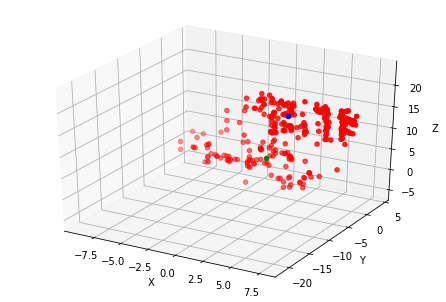

In [164]:
root= os.getcwd()
P_1 = np.loadtxt(root + '/data/library1_camera.txt')
P_2 = np.loadtxt(root + '/data/library2_camera.txt')
matches = np.loadtxt(root + '/data/library_matches.txt')

center_1 = get_center(P_1)
center_2 = get_center(P_2)
pos_3d= triangulation(P_1, P_2, matches)

pos_3d = pos_3d[:, :-1]
print(pos_3d.shape)
points_1 = matches[:, 0:2]
points_2 = matches[:, 2:4]
points_3d_proj, res_1 = evaluate_points(P_1, points_1, pos_3d)
points_3d_proj, res_2 = evaluate_points(P_2, points_2, pos_3d)
#center1, center2, X_3D = triangulate(P_1, P_2, matches)
#avg_res1, avg_res2 = get_residual(P_1, P_2, pos_3d, matches)
#print(avg_res1, avg_res2)
print(res_1, res_2)
plot_3d(center_1, center_2, pos_3d)